<b><h1>RVL CDIP</b>

Data Source:https://www.cs.cmu.edu/~aharley/rvl-cdip/

There are 400,000 total document images in the dataset.  Uncompressed, the dataset size is ~100GB, and comprises 16 classes of document types, with 25,000 samples per classes. Example classes include email, resume, and invoice.

<b>Objective:</b>

For a given image classify it into one of the 16 classes.

Categories are numbered 0 to 15, in the following order:

0. letter

1. form

2. email

3. handwritten

4. advertisement

5. scientific report

6. scientific publication

7. specification

8. file folder

9. news article

10. budget

11. invoice

12. presentation

13. questionnaire

14. resume

15. memo



In [1]:
import tensorflow as tf
import scipy
import scipy.misc
import random
import os
from tensorflow.core.protobuf import saver_pb2
import numpy as np
import matplotlib.pyplot as plt

# Loading Dataset

In [2]:

#load dataset
xs = []
ys = []
#read data.txt
with open("labels/train.txt") as f:
    for line in f:
        xs.append("images/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append((line.split()[1]))



# Creating a DataFrame 

In [3]:
import pandas as pd
df = pd.DataFrame(list(zip(xs, ys)), 
               columns =['name of image', 'label']) 
df.head(5)

,name of image,label
0,images/imagesq/q/o/c/qoc54c00/80035521.tif,15
1,images/imagese/e/w/c/ewc23d00/513280028.tif,1
2,images/imagesw/w/b/t/wbt26e00/2053453161.tif,7
3,images/imagesm/m/k/m/mkm05e00/2040792992_20407...,10
4,images/imageso/o/e/x/oex80d00/522787731+-7732.tif,3


# TAKING ONLY 5000 IMAGES FROM EACH CLASS

In [4]:
final=df.groupby('label').tail(5000).reset_index(drop=True)

final.shape

(80000, 2)

In [5]:
final['label'].value_counts()

10    5000
3     5000
9     5000
4     5000
5     5000
6     5000
1     5000
14    5000
0     5000
12    5000
13    5000
15    5000
8     5000
11    5000
2     5000
7     5000
Name: label, dtype: int64

In [6]:
final.head()

,name of image,label
0,images/imagest/t/u/j/tuj59c00/PUBLICATIONS0049...,6
1,images/imagesi/i/u/w/iuw00a00/10335830_1033586...,6
2,images/imagesp/p/o/p/pop52d00/2501721968_1976.tif,6
3,images/imagesv/v/r/s/vrs23e00/2057827131.tif,6
4,images/imagesf/f/k/t/fkt36d00/50612597-2601.tif,6


In [7]:
f = final.sample(frac=1).reset_index(drop=True)

In [8]:
f.head()

,name of image,label
0,images/imagesp/p/l/g/plg05c00/2064221634.tif,8
1,images/imagesm/m/k/a/mka15c00/2073816108.tif,8
2,images/imagesd/d/v/i/dvi03c00/2084614507.tif,1
3,images/imageso/o/p/q/opq11d00/522714306+-4307.tif,3
4,images/imagesw/w/q/u/wqu80d00/522931649+-1650.tif,3


# EDA

### Image resolution for each class

In [22]:
dictonary={"0":'letter',"1":'form',"2" :'email',"3":'handwritten',"4":'advertisement',"5":'scientific report',"6":'scientific publication',"7":'specification',"8":'file folder',"9":'news article',"10":'budget',"11":'invoice',"12":'presentation',"13":'questionnaire',"14":'resume',"15":'memo'}

In [23]:
sample=f.groupby('label').head(1).reset_index(drop=True)

sample.shape

(16, 2)

In [24]:
sample.head()

,name of image,label
0,images/imagesl/l/k/a/lka66d00/517951174+-1179.tif,4
1,images/imagesp/p/s/p/psp4aa00/10413356_1041335...,6
2,images/imagesw/w/i/l/wil82a00/527929403+-9403.tif,2
3,images/imagesi/i/c/z/icz51e00/03743837.tif,15
4,images/imagesh/h/g/s/hgs32d00/2028581788_1789.tif,1


In [25]:
image_name=list(sample['name of image'].values)
label=list(sample['label'].values)

In [26]:
from tqdm import tqdm
import cv2
img_data_listtr=[]
labels=[]
for i in tqdm(range(16)):
    input_img=cv2.imread(image_name[i])
    if input_img is not None:
        input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB) 
        img_data_listtr.append(input_img.shape)
        labels.append(dictonary.get(label[i],-1))

        

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 24.58it/s]


In [27]:
df1 = pd.DataFrame(list(zip(img_data_listtr, labels)), 
               columns =[' image size', 'label']) 

In [28]:
df1.head(16)

,image size,label
0,"(1000, 754, 3)",advertisement
1,"(1000, 772, 3)",scientific publication
2,"(1000, 754, 3)",email
3,"(1000, 765, 3)",memo
4,"(1000, 754, 3)",form
5,"(1000, 777, 3)",invoice
6,"(1000, 754, 3)",handwritten
7,"(1000, 796, 3)",budget
8,"(1000, 777, 3)",letter
9,"(1000, 762, 3)",file folder


### 1. Inter-class similarity  i.e. the visual appearance of documents between different classes can be very similar.

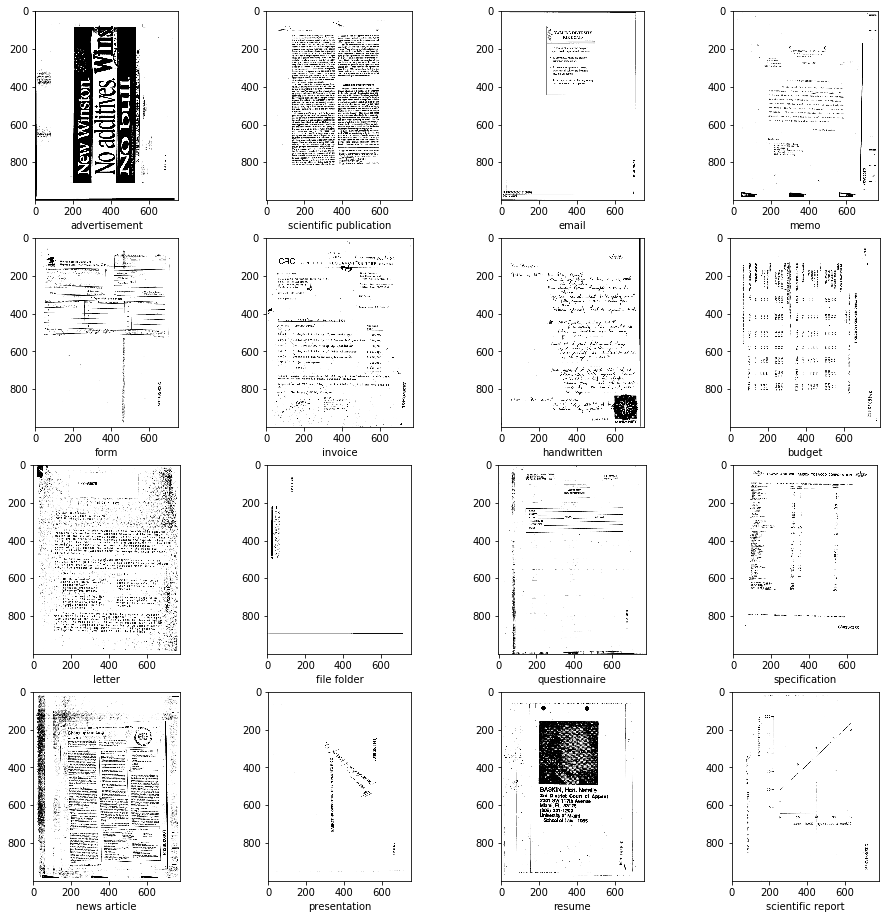

In [29]:
rows=4
columns=4
fig=plt.figure(figsize=(16, 16))
for i in range(1, columns*rows +1):
    input_img=cv2.imread(image_name[i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(input_img)
    plt.xlabel(dictonary.get(label[i-1],-1))
plt.show()


We can see that scientific report,letter,newsarticle are looking similar. This may impact our performance.

### 2.Intra-class variability i.e.visual appearance of documents within a same class can strongly vary.


In [30]:
sorted_final=final.sort_values('label', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [31]:
letter=sorted_final[:6]

In [32]:
image_name=list(letter['name of image'].values)
label=list(letter['label'].values)

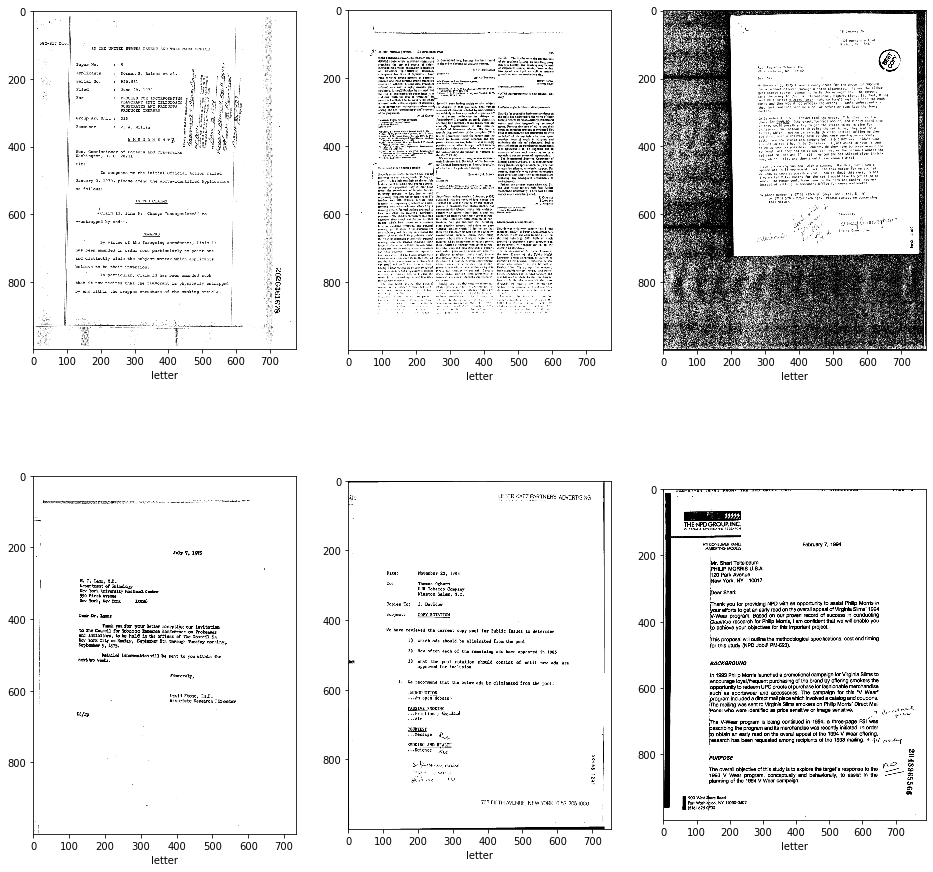

In [33]:
rows=2
columns=3
fig=plt.figure(figsize=(16, 16))
for i in range(1, columns*rows +1):
    input_img=cv2.imread(image_name[i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(input_img)
    plt.xlabel(dictonary.get(label[i-1],-1))
plt.show()


We can clearly notice the difference between each letter.It can confuse the Model.

# APPROACH

For this classification we will do following steps:
    
1.Preprocess image:
    
    a.resize it to 224*224
    
    b.divide each value by 255

       
2.<b>transfer learning vgg16</b>: Transfer learning(VGG16) with fine tuning last layers.

<img src='rvl.png'>

3.We will not do region based learning as it gives almost same result as holistic but with cost of lot of time.ref:https://www.cs.cmu.edu/~aharley/rvl-cdip/
        
  

# preprocessing 

In [12]:
from keras.preprocessing.image import ImageDataGenerator

tr=f[:65000]
cv=f[65000:75000]
test=f[75000:]

In [10]:
datagen = ImageDataGenerator(rescale=1./255)

#test_datagen = ImageDataGenerator(rescale=1./255)



In [12]:
train_generator = datagen.flow_from_dataframe(tr, directory=None, x_col='name of image', y_col='label',
                                                    target_size=(224, 224), color_mode='rgb',
                                                    classes=None ,class_mode='categorical', batch_size=32, 
                                                    shuffle=True)



Found 65000 validated image filenames belonging to 16 classes.


In [13]:
cv_generator = datagen.flow_from_dataframe(cv, directory=None, x_col='name of image', y_col='label',
                                                    target_size=(224,224), color_mode='rgb',
                                                    classes=None ,class_mode='categorical', batch_size=32, 
                                                    shuffle=True)



Found 10000 validated image filenames belonging to 16 classes.


In [14]:
test_generator = datagen.flow_from_dataframe(test, directory=None, x_col='name of image', y_col='label',
                                                    target_size=(224,224), color_mode='rgb',
                                                    classes=None ,class_mode='categorical', batch_size=32, 
                                                    shuffle=True)



Found 5000 validated image filenames belonging to 16 classes.


# transfer learning using vgg16

In [10]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

Using TensorFlow backend.


In [16]:
model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))
# Freeze the layers which you don't want to train. Here I am freezing the first 15 layers.
for layer in model.layers[:17]:
    layer.trainable = False

#Adding custom Layers 

x = model.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(4096, activation="relu")(x)

predictions = Dense(16, activation="softmax")(x)

# creating the final model 
model_final = Model(input = model.input, output = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])


W0915 04:17:49.875283  4592 deprecation_wrapper.py:119] From C:\Users\aksha\Anaconda3\envs\gputest\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0915 04:17:49.901175  4592 deprecation_wrapper.py:119] From C:\Users\aksha\Anaconda3\envs\gputest\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0915 04:17:49.907160  4592 deprecation_wrapper.py:119] From C:\Users\aksha\Anaconda3\envs\gputest\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0915 04:17:49.945092  4592 deprecation_wrapper.py:119] From C:\Users\aksha\Anaconda3\envs\gputest\lib\site-packages\keras\backend\tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0915 04:17:50.804262  4592

In [17]:
model_final.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [18]:
history=model_final.fit_generator(train_generator,steps_per_epoch=2032,epochs=7,validation_data=cv_generator,validation_steps=313,verbose=1)

W0915 04:18:00.975017  4592 deprecation.py:323] From C:\Users\aksha\Anaconda3\envs\gputest\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/7
2032/2032 [==============================] - 4211s 2s/step - loss: 1.3135 - acc: 0.6007 - val_loss: 0.9731 - val_acc: 0.7075
Epoch 2/7
2032/2032 [==============================] - 4205s 2s/step - loss: 0.9779 - acc: 0.7068 - val_loss: 0.9521 - val_acc: 0.7245
Epoch 3/7
2032/2032 [==============================] - 4222s 2s/step - loss: 0.8824 - acc: 0.7343 - val_loss: 0.8567 - val_acc: 0.7434
Epoch 4/7
2032/2032 [==============================] - 4222s 2s/step - loss: 0.8112 - acc: 0.7570 - val_loss: 0.8708 - val_acc: 0.7465
Epoch 5/7
2032/2032 [==============================] - 4231s 2s/step - loss: 0.7627 - acc: 0.7697 - val_loss: 0.8135 - val_acc: 0.7596
Epoch 6/7
2032/2032 [==============================] - 4235s 2s/step - loss: 0.7223 - acc: 0.7816 - val_loss: 0.8054 - val_acc: 0.7674
Epoch 7/7
2032/2032 [==============================] - 4218s 2s/step - loss: 0.6913 - acc: 0.7912 - val_loss: 0.7952 - val_acc: 0.7675


In [19]:
score = model_final.evaluate_generator(test_generator, verbose=0)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])


Test score: 0.810308811378479
Test accuracy: 0.7686


In [20]:
x = list(range(1,8))
vy = history.history['val_loss']
ty = history.history['loss']
def plot(x,ty,vy):
    plt.xlabel("epochs")
    plt.ylabel("cross entropy error")
    plt.plot(x,vy,'b', label="Validation Loss")
    plt.plot(x,ty,'r', label="Train Loss")
    plt.legend()
    plt.show()
  
  

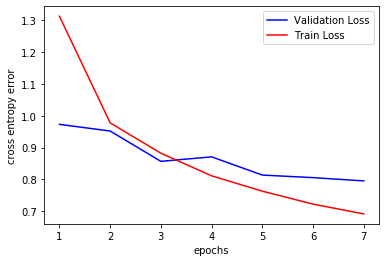

In [21]:
plot(x,ty,vy)

# conclusion

I got 7 percent increase in accuracy with transfer learning.

In [2]:
from prettytable import PrettyTable

# Initializing table object
x = PrettyTable()

x.field_names = ["Model","train accuracy","test accuracy "]
x.add_row(["vgg16 tranfer learning","0.79","0.77" ])

print(x)

+------------------------+----------------+----------------+
|         Model          | train accuracy | test accuracy  |
+------------------------+----------------+----------------+
| vgg16 tranfer learning |      0.79      |      0.77      |
+------------------------+----------------+----------------+
